### Script designed to adress Research Question 2: 

- Does interpersonal coordination covary with the differences in partners’ conflict communication?

Hypotheses: 

- H3: Couples coordination will covary with the extent to which the target and agent differ in their negative-direct and negative-indirect communication ratings.
- H4: Couples coordination will covary with the extent to which the target and agent differ in their positive-direct and positive-indirect communication ratings.

In [ ]:
# Import relevant packages
from tqdm import tqdm as tqdm
import pandas as pd
from lmm_utils import *

# Load data
merged_crqa = pd.read_csv('/..../CRQA_Outputs/merged_crqa_iaaft.csv') # Load CRQA data
roles = pd.read_csv('role_metadata.csv') # Load role metadata
oua_conv = pd.read_csv("/..../Relationship_Measures/ConvScores_Succ.csv") # Load OuA Conversation Interval Data

In [2]:
# Prepare Dataframes.

# Select appropriate DVs
dv_cols = [col for col in merged_crqa.columns if col.endswith(tuple(['REC', 'DET', 'MAXLINE', 'ENTROPY', 'LAM']))] # Select DVs.

# Remove causal discussion trials
merged_crqa = merged_crqa[merged_crqa['trial'] != 'trial0'] # Remove casual discussion

# Remove outliers
merged_crqa = merged_crqa[merged_crqa['couple'] != 37] # %REC > 5std from mean. 

# Define roles from the metadata
roles = roles[['couple', 'trial', 'agent_gen', 'target_gen']]

# Merge roles with the CRQA data
merged_crqa = pd.merge(merged_crqa, roles, on=['couple', 'trial'])

#print 
merged_crqa.head(10)

,window_index,head_ed_vel_REC,head_ed_vel_DET,head_ed_vel_MAXLINE,head_ed_vel_ENTROPY,head_ed_vel_MEANLINE,head_ed_vel_LAM,head_ed_vel_DIV,head_ed_vel_MAXL_POSS,head_ed_vel_err_code,...,body_ed_vel_MEANLINE,body_ed_vel_LAM,body_ed_vel_DIV,body_ed_vel_MAXL_POSS,body_ed_vel_err_code,couple,trial,pair,agent_gen,target_gen
0,0,9.060895,64.517091,47.5,1.901112,3.120229,0.789847,0.021954,1484.0,0.0,...,2.385414,0.636426,0.044332,1484.0,0.0,127,trial1,pseudo,-1,1
1,1,7.763198,49.422034,31.6,1.473767,2.640126,0.760700,0.033648,1484.0,0.0,...,2.146345,0.493909,0.102174,1484.0,0.0,127,trial1,pseudo,-1,1
2,2,3.834223,23.014029,9.4,0.819549,2.223702,0.692586,0.113843,1484.0,0.0,...,2.028928,0.431904,0.308333,1484.0,0.0,127,trial1,pseudo,-1,1
3,3,7.211219,48.534597,30.6,1.446344,2.613011,0.738854,0.035215,1484.0,0.0,...,2.118469,0.272715,0.157024,1484.0,0.0,127,trial1,pseudo,-1,1
4,4,7.295192,44.025987,23.6,1.269979,2.461125,0.760990,0.046663,1484.0,0.0,...,2.085742,0.189394,0.189210,1484.0,0.0,127,trial1,pseudo,-1,1
5,5,6.236250,39.157781,21.3,1.224388,2.445514,0.681063,0.048835,1484.0,0.0,...,2.034205,0.108479,0.283333,1484.0,0.0,127,trial1,pseudo,-1,1
6,6,8.640648,50.139782,28.6,1.433965,2.609362,0.681510,0.037536,1484.0,0.0,...,2.106927,0.161606,0.173922,1484.0,0.0,127,trial1,pseudo,-1,1
7,7,2.636860,11.873507,4.8,0.320240,2.060700,0.669554,0.222778,1484.0,0.0,...,2.092091,0.273679,0.206667,1484.0,0.0,127,trial1,pseudo,-1,1
8,8,2.001089,10.178354,3.9,0.248669,2.047394,0.662963,0.261667,1484.0,0.0,...,2.018144,0.295580,0.308333,1484.0,0.0,127,trial1,pseudo,-1,1
9,9,5.592125,44.826811,25.9,1.396268,2.575411,0.721605,0.040953,1484.0,0.0,...,2.020598,0.243975,0.316667,1484.0,0.0,127,trial1,pseudo,-1,1


In [2]:
"""
Compute rolling average to align conversation score with CRQA window index.

DataFrame 'merged_roll' contains the crqa and conversation(OUA) data.
DataFrame 'conv' contains the rolling average conversation scores.
"""

# Function to compute rolling average
def rolling_avg(group):
    cols = ['AG_NDirect', 'AG_NIndirect', 'AG_PosDirect', 'AG_PosIndirect',
            'TG_NDirect', 'TG_NIndirect', 'TG_PosDirect', 'TG_PosIndirect']
    
    for col in cols:
        # rolling average of current and next row
        group[f'{col}_roll'] = (group[col] + group[col].shift(-1)) / 2
    
    # window_index aligns with time - 1
    group['window_index'] = group['time'] - 1
    
    return group

# Apply rolling average function to each couple and trial
conv = oua_conv.groupby(['couple', 'trial'], group_keys=False).apply(rolling_avg)

# Select relevant columns
conv = conv[['couple', 'trial', 'window_index'] + 
            [f'{col}_roll' for col in ['AG_NDirect', 'AG_NIndirect', 'AG_PosDirect', 'AG_PosIndirect',
                                       'TG_NDirect', 'TG_NIndirect', 'TG_PosDirect', 'TG_PosIndirect']]]

# Merge CRQA data with rolling average conversation scores
merged_roll = pd.merge(merged_crqa, conv, on=['couple', 'trial', 'window_index'])

# Print
merged_roll.head(10)

/var/folders/41/ps8z2q_j48399th9s8y545xr0000gn/T/ipykernel_33324/404884367.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conv = oua_conv.groupby(['couple', 'trial'], group_keys=False).apply(rolling_avg)


,window_index,head_ed_vel_REC,head_ed_vel_DET,head_ed_vel_MAXLINE,head_ed_vel_ENTROPY,head_ed_vel_MEANLINE,head_ed_vel_LAM,head_ed_vel_DIV,head_ed_vel_MAXL_POSS,head_ed_vel_err_code,...,trial,pair,AG_NDirect_roll,AG_NIndirect_roll,AG_PosDirect_roll,AG_PosIndirect_roll,TG_NDirect_roll,TG_NIndirect_roll,TG_PosDirect_roll,TG_PosIndirect_roll
0,0,9.060895,64.517091,47.5,1.901112,3.120229,0.789847,0.021954,1484.0,0.0,...,trial1,pseudo,1.00,2.00,2.25,3.00,2.50,1.25,2.00,2.00
1,1,7.763198,49.422034,31.6,1.473767,2.640126,0.760700,0.033648,1484.0,0.0,...,trial1,pseudo,1.00,1.75,2.50,3.00,2.00,1.75,2.50,2.25
2,2,3.834223,23.014029,9.4,0.819549,2.223702,0.692586,0.113843,1484.0,0.0,...,trial1,pseudo,1.25,2.00,3.00,2.50,2.00,1.75,1.50,2.00
3,3,7.211219,48.534597,30.6,1.446344,2.613011,0.738854,0.035215,1484.0,0.0,...,trial1,pseudo,1.25,1.75,3.75,2.50,2.25,1.25,1.25,1.75
4,4,7.295192,44.025987,23.6,1.269979,2.461125,0.760990,0.046663,1484.0,0.0,...,trial1,pseudo,1.00,1.75,3.50,2.50,1.25,1.00,2.25,2.00
5,5,6.236250,39.157781,21.3,1.224388,2.445514,0.681063,0.048835,1484.0,0.0,...,trial1,pseudo,1.75,1.75,2.75,2.25,1.50,1.75,2.50,2.25
6,6,8.640648,50.139782,28.6,1.433965,2.609362,0.681510,0.037536,1484.0,0.0,...,trial1,pseudo,2.50,1.50,2.75,2.50,1.50,1.75,1.50,2.25
7,7,2.636860,11.873507,4.8,0.320240,2.060700,0.669554,0.222778,1484.0,0.0,...,trial1,pseudo,3.00,1.75,3.00,2.25,1.25,1.00,1.00,1.75
8,8,2.001089,10.178354,3.9,0.248669,2.047394,0.662963,0.261667,1484.0,0.0,...,trial1,pseudo,2.75,2.00,3.00,2.25,1.75,1.50,1.25,1.75
9,9,5.592125,44.826811,25.9,1.396268,2.575411,0.721605,0.040953,1484.0,0.0,...,trial1,pseudo,1.50,2.25,3.00,3.25,1.50,1.75,1.25,2.25


In [3]:
# Calculate difference scores for each conversation style.

merged_roll['PosDirect_diff'] = merged_roll['AG_PosDirect_roll'] - merged_roll['TG_PosDirect_roll']
merged_roll['PosIndirect_diff'] = merged_roll['AG_PosIndirect_roll'] - merged_roll['TG_PosIndirect_roll']
merged_roll['NDirect_diff'] = merged_roll['AG_NDirect_roll'] - merged_roll['TG_NDirect_roll']
merged_roll['NIndirect_diff'] = merged_roll['AG_NIndirect_roll'] - merged_roll['TG_NIndirect_roll']

print(merged_roll[['PosIndirect_diff', 'AG_PosIndirect_roll', 'TG_PosIndirect_roll']])

      PosIndirect_diff  AG_PosIndirect_roll  TG_PosIndirect_roll
0                 1.00                 3.00                 2.00
1                 0.75                 3.00                 2.25
2                 0.50                 2.50                 2.00
3                 0.75                 2.50                 1.75
4                 0.50                 2.50                 2.00
...                ...                  ...                  ...
6049              0.75                 2.75                 2.00
6050              1.00                 2.75                 1.75
6051              1.50                 3.00                 1.50
6052              1.25                 2.50                 1.25
6053              1.50                 2.75                 1.25

[6054 rows x 3 columns]


In [4]:
# Convert to long format and collapse data for analysis 

DVs = [col for col in merged_roll.columns 
       if col.endswith(('REC', 'DET', 'MAXLINE', 'ENTROPY', 'LAM'))]

# Columns representing differences
cols_diff = ["PosDirect_diff", "PosIndirect_diff", "NDirect_diff", "NIndirect_diff"]

# Melt into long format
roll_diff = merged_roll.melt(
    id_vars=["couple", "trial", "pair"] + DVs,
    value_vars=cols_diff,
    var_name="conv_type",
    value_name="diff"
)

# Clean the '_diff' suffix
roll_diff["conv_type"] = roll_diff["conv_type"].str.replace("_diff", "", regex=False)

# Drop NA difference rows
roll_diff = roll_diff.dropna(subset=["diff"])

# Build list of columns to aggregate
roll_cols = DVs.copy()
roll_cols.append("diff")

# Aggregate
roll_diff = (
    roll_diff
    .groupby(['couple', 'trial', 'conv_type', 'pair'])[roll_cols]
    .mean()
    .reset_index()
)

# Print
roll_diff.head(10)


,couple,trial,conv_type,pair,head_ed_vel_REC,head_ed_vel_DET,head_ed_vel_MAXLINE,head_ed_vel_ENTROPY,head_ed_vel_LAM,headRel_ed_vel_REC,headRel_ed_vel_DET,headRel_ed_vel_MAXLINE,headRel_ed_vel_ENTROPY,headRel_ed_vel_LAM,body_ed_vel_REC,body_ed_vel_DET,body_ed_vel_MAXLINE,body_ed_vel_ENTROPY,body_ed_vel_LAM,diff
0,1,trial1,NDirect,actual,9.002344,57.633262,41.333333,1.723512,0.677723,4.173308,23.895679,16.250000,0.960269,0.441816,4.833086,23.292420,15.916667,0.853960,0.467768,0.222222
1,1,trial1,NDirect,pseudo,7.757101,57.152478,34.941667,1.752705,0.713060,4.190109,28.237600,15.983333,0.966028,0.467458,5.307700,31.736649,17.183333,1.018438,0.542717,0.222222
2,1,trial1,NIndirect,actual,9.002344,57.633262,41.333333,1.723512,0.677723,4.173308,23.895679,16.250000,0.960269,0.441816,4.833086,23.292420,15.916667,0.853960,0.467768,0.444444
3,1,trial1,NIndirect,pseudo,7.757101,57.152478,34.941667,1.752705,0.713060,4.190109,28.237600,15.983333,0.966028,0.467458,5.307700,31.736649,17.183333,1.018438,0.542717,0.444444
4,1,trial1,PosDirect,actual,9.002344,57.633262,41.333333,1.723512,0.677723,4.173308,23.895679,16.250000,0.960269,0.441816,4.833086,23.292420,15.916667,0.853960,0.467768,0.486111
5,1,trial1,PosDirect,pseudo,7.757101,57.152478,34.941667,1.752705,0.713060,4.190109,28.237600,15.983333,0.966028,0.467458,5.307700,31.736649,17.183333,1.018438,0.542717,0.486111
6,1,trial1,PosIndirect,actual,9.002344,57.633262,41.333333,1.723512,0.677723,4.173308,23.895679,16.250000,0.960269,0.441816,4.833086,23.292420,15.916667,0.853960,0.467768,-1.791667
7,1,trial1,PosIndirect,pseudo,7.757101,57.152478,34.941667,1.752705,0.713060,4.190109,28.237600,15.983333,0.966028,0.467458,5.307700,31.736649,17.183333,1.018438,0.542717,-1.791667
8,1,trial2,NDirect,actual,5.852135,50.869217,36.857143,1.661207,0.695134,3.410944,21.645017,16.000000,0.832874,0.400870,5.748586,32.327498,18.142857,1.043963,0.543419,-0.642857
9,1,trial2,NDirect,pseudo,5.652836,52.974849,29.785714,1.568162,0.731842,3.394446,25.679282,15.114286,0.904572,0.491419,5.694232,37.018928,22.357143,1.165683,0.629486,-0.642857


In [5]:
# Compute descriptives of conversation scores (split by agent vs target).

def descriptives(data, groupby=None, cols=None):
    if cols is None:
        cols = data.select_dtypes(include="number").columns
    
    if groupby:
        # Compute grouped descriptives
        desc = (
            data.groupby(groupby)[cols]
            .agg(["mean", "std", "min", "max", "median", "count"])
        )

        # Convert wide multi-index columns → tidy long format
        desc = (
            desc.stack(level=0)
                .rename_axis([*groupby, "variable"])
                .reset_index()
        )

    else:
        # No grouping → compute descriptives for whole dataset
        desc = (
            data[cols]
            .agg(["mean", "std", "min", "max", "median", "count"])
            .T
            .reset_index()
            .rename(columns={"index": "variable"})
        )
    
    return desc

# Example: descriptives for each conv_type
desc = descriptives(merged_roll, groupby=["trial"], cols=[
    "AG_NDirect_roll", "TG_NDirect_roll",
    "AG_PosDirect_roll", "TG_PosDirect_roll",
    "AG_NIndirect_roll", "TG_NIndirect_roll",
    "AG_PosIndirect_roll", "TG_PosIndirect_roll"
])

print(desc.head(16))

     trial             variable      mean       std  min       max    median  \
0   trial1      AG_NDirect_roll  1.983488  1.180714  1.0  7.000000  1.500000   
1   trial1    AG_NIndirect_roll  1.842963  0.956407  1.0  5.750000  1.500000   
2   trial1    AG_PosDirect_roll  2.655757  0.966529  1.0  5.833333  2.666667   
3   trial1  AG_PosIndirect_roll  2.481007  0.977841  1.0  5.750000  2.500000   
4   trial1      TG_NDirect_roll  1.744238  1.046768  1.0  6.500000  1.250000   
5   trial1    TG_NIndirect_roll  1.795695  0.923156  1.0  5.750000  1.500000   
6   trial1    TG_PosDirect_roll  2.648794  1.028816  1.0  7.000000  2.500000   
7   trial1  TG_PosIndirect_roll  2.520807  0.898292  1.0  5.500000  2.500000   
8   trial2      AG_NDirect_roll  1.887133  1.107644  1.0  6.000000  1.500000   
9   trial2    AG_NIndirect_roll  1.861159  1.033945  1.0  7.000000  1.500000   
10  trial2    AG_PosDirect_roll  2.817498  1.021846  1.0  7.000000  2.750000   
11  trial2  AG_PosIndirect_roll  2.62719

/var/folders/41/ps8z2q_j48399th9s8y545xr0000gn/T/ipykernel_33324/1446587031.py:16: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  desc.stack(level=0)


In [6]:
# Summary Statistics 
dv = 'headRel_ed_vel_REC' # select variable

# Trial-level stats
trial_stats = merged_roll.groupby(['trial', 'pair'])[dv].agg(['mean', 'std', 'min', 'max', 'count'])
trial_stats = trial_stats.rename(columns={'count': 'num_couples'})
print("Trial-level stats:\n", trial_stats)

# Overall stats (across all trials)
overall_stats = roll_diff[dv].agg(['mean', 'std', 'min', 'max'])
overall_stats['num_couples'] = roll_diff['couple'].nunique()
print("\nOverall stats:\n", overall_stats)


Trial-level stats:
                    mean       std       min        max  num_couples
trial  pair                                                        
trial1 actual  3.457881  2.583102  0.901394  63.215357         1564
       pseudo  3.555158  2.448959  0.762831  61.308149         1564
trial2 actual  3.253318  1.811825  0.734065  46.865896         1463
       pseudo  3.354911  1.668238  0.686065  41.990600         1463

Overall stats:
 mean             3.421704
std              1.131407
min              1.420264
max             12.329364
num_couples    131.000000
Name: headRel_ed_vel_REC, dtype: float64


In [7]:
# Create orthogonal polynomial contrasts for window index (if needed)

from numpy.polynomial.legendre import legvander

# Prep data if windowed
merged_roll['window_index'] = merged_roll['window_index'] 

merged_roll['window_scaled'] = 2 * (merged_roll['window_index'] - merged_roll['window_index'].min()) / (merged_roll['window_index'].max() - merged_roll['window_index'].min()) - 1

# CREATE  2nd-order orthogonal polynomials
X = legvander(merged_roll['window_scaled'], deg=2)

# add to dataframe
merged_roll['ot1'] = X[:, 1]  # linear orthogonal component
merged_roll['ot2'] = X[:, 2]  # quadratic orthogonal component

In [ ]:
# Conduct Linear Mixed Effects Models

# Create copy of dataframe for analysis
df = roll_diff.copy()

# Center continuous predictors
df['diff_c'] = df['diff'] - df['diff'].mean() # Center collapsed difference scores

# Select DV to analyse
DVs = [col for col in df.columns if col.endswith('headRel_ed_vel_REC')] 

p_values = {}
effect_sizes = {}
conf_intervals = {}
r2_values = {}

categorical_vars = ['conv_type']
for var in categorical_vars:
    df[var] = df[var].astype('category')

simple_effects = []

for dv in DVs:
    
    formula = f"{dv} ~ diff * C(conv_type, Treatment(reference='NDirect')) * C(pair, Treatment(reference='actual'))"
    
    try:
        model = smf.mixedlm(
            formula,
            df,
            groups=df["couple"]
        ).fit(reml=True)

        print(f"\nMixed-Effects Model for {dv}:")
        R2_m, R2_c = r2_marginal_conditional(model)
        print(f"Marginal R² (fixed): {R2_m:.3f}")
        print(f"Conditional R² (fixed + random): {R2_c:.3f}")
        print(model.summary())

    except Exception as e:
        print(f"Error fitting model for {dv}: {e}")




Mixed-Effects Model for headRel_ed_vel_REC:
Marginal R² (fixed): 0.013
Conditional R² (fixed + random): 0.771
                                                           Mixed Linear Model Regression Results
Model:                                            MixedLM                               Dependent Variable:                               headRel_ed_vel_REC
No. Observations:                                 2088                                  Method:                                           REML              
No. Groups:                                       131                                   Scale:                                            0.3002            
Min. group size:                                  8                                     Log-Likelihood:                                   -1996.3210        
Max. group size:                                  16                                    Converged:                                        Yes               
Mean gr

In [10]:
"""
This sections used to compute estimated marginal means, pairwise comparisons, and simple slopes. 

Function (emmeans_with_slopes_rm) parameters:
    - model: The LMM fitted above. 
    - factors: Categorical IVs included in the model
    - covariates: Continuous IVs included in the model
    - p_correction: Method for p-value correction. (Alternatives: 'bonferroni', 'holm', None).
    - comparison_type: Type of pairwise comparisons to perform. Relevant options include (besides None):
        NOTE: Options assume IVs pair and trial. If pair is not included, set comparison_type = 'all' or None.
Outputs: 
    - emmeans_df: Estimated marginal means for each factor level at covariate = 0 (mean centered).
    - slopes_df: Simple slopes for each covariate.
    - pairwise_df: Pairwise comparisons.
    - slope_contrasts_df: Contrasts of simple slopes.
"""

emmeans_df, slopes_df, pairwise_df, slope_contrasts_df = emmeans_with_slopes_rm(model, 
                                                                                  factors=["conv_type", 'pair'],
                                                                                  covariates=["diff"],
                                                                                  p_correction="fdr_bh",
                                                                                  comparison_type='all'
                                                                                  )

print(emmeans_df)
print("\n------------------------------------------------------------------------\n")
# Simple slopes
print(slopes_df)
print("\n------------------------------------------------------------------------\n")
print(pairwise_df)

     conv_type    pair  diff   emmeans        se     lower     upper
0      NDirect  actual     0  3.300414  0.081368  3.140843  3.459986
1      NDirect  pseudo     0  3.401856  0.081368  3.242284  3.561428
2    NIndirect  actual     0  3.326083  0.081228  3.166786  3.485380
3    NIndirect  pseudo     0  3.424903  0.081228  3.265607  3.584200
4    PosDirect  actual     0  3.340257  0.081431  3.180561  3.499953
5    PosDirect  pseudo     0  3.440601  0.081431  3.280905  3.600297
6  PosIndirect  actual     0  3.346791  0.081374  3.187208  3.506375
7  PosIndirect  pseudo     0  3.442624  0.081374  3.283041  3.602208

------------------------------------------------------------------------

     conv_type    pair covariate     slope        se         t      p  \
0      NDirect  actual      diff  0.153329  0.034567  4.435694  0.000   
1      NDirect  pseudo      diff  0.139910  0.034567  4.047490  0.000   
2    NIndirect  actual      diff  0.058018  0.028102  2.064518  0.039   
3    NIndire

/Users/robertopizzin/GitHub/Mres-Repo/stats/lmm_utils.py:454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slopes_df['valence'] = slopes_df['conv_type'].map(valence_map)
/Users/robertopizzin/GitHub/Mres-Repo/stats/lmm_utils.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slopes_df['type'] = slopes_df['conv_type'].map(type_map)
/Users/robertopizzin/GitHub/Mres-Repo/stats/lmm_utils.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

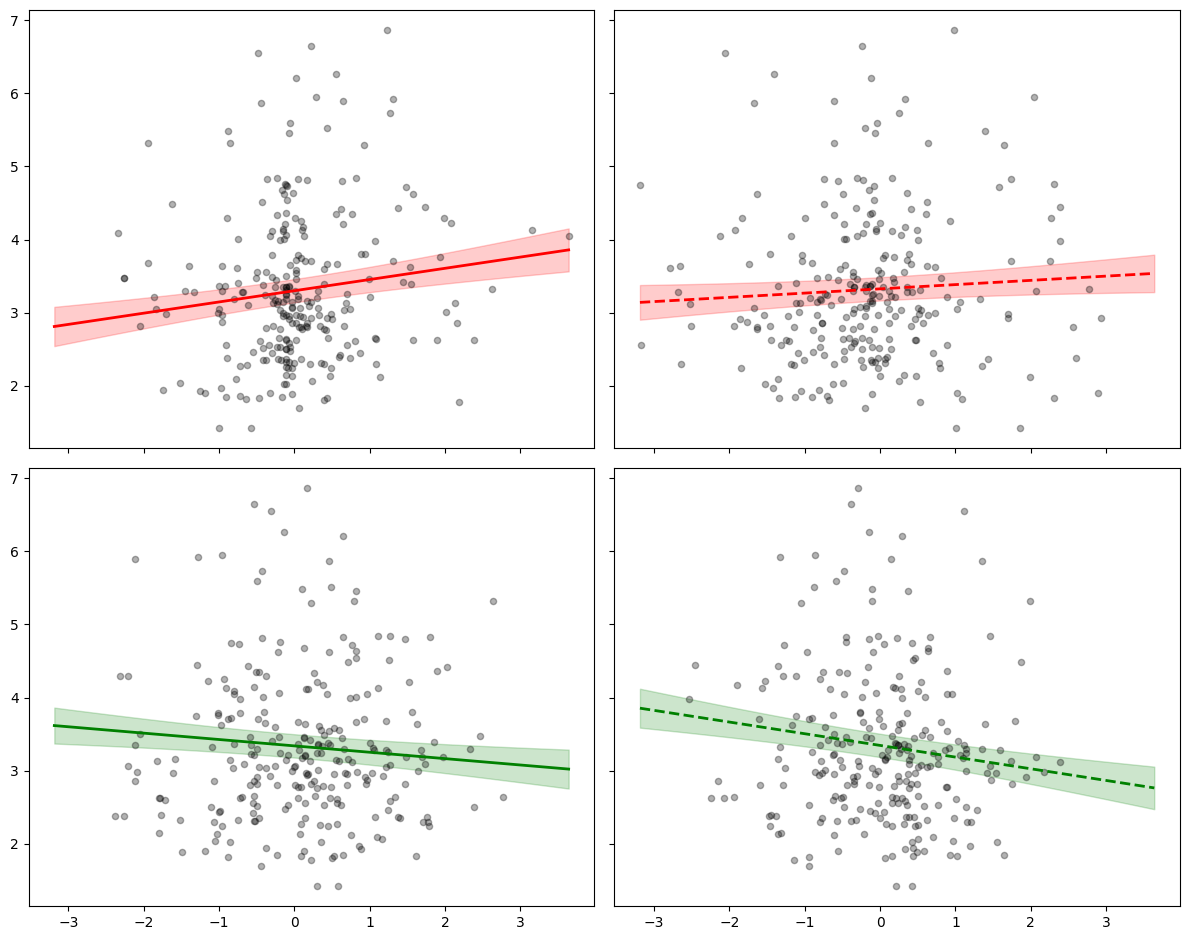

In [11]:
# Graph Simple Slopes 

# Note: Make sur DV matches the analysis above.
plot_conv_slopes(emmeans_df, slopes_df, df, covariate='diff_c', dv='headRel_ed_vel_REC', datatype='actual', display=False) # datatype = 'actual' or 'pseudo'





-------------------- TESTING DV: headRel_ed_vel_REC --------------------


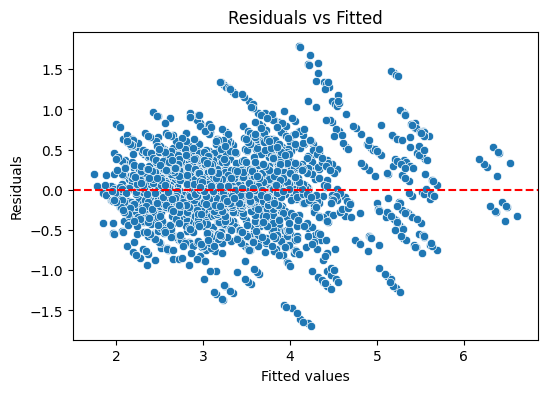

Breusch-Pagan test could not be performed: name 'het_breuschpagan' is not defined


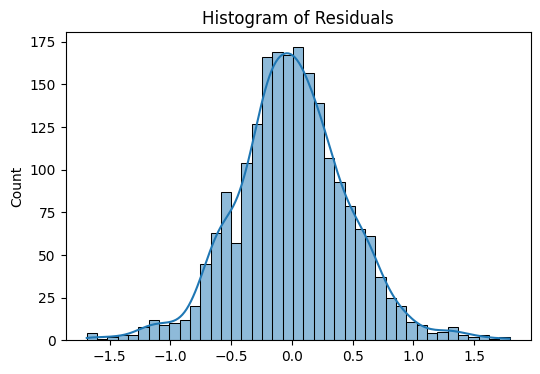

Shapiro-Wilk test for residuals: stat=0.993, p=0.000
Residuals NOT Gaussian (reject H0)
D'Agostino-Pearson test for residuals: stat=35.886, p=0.000


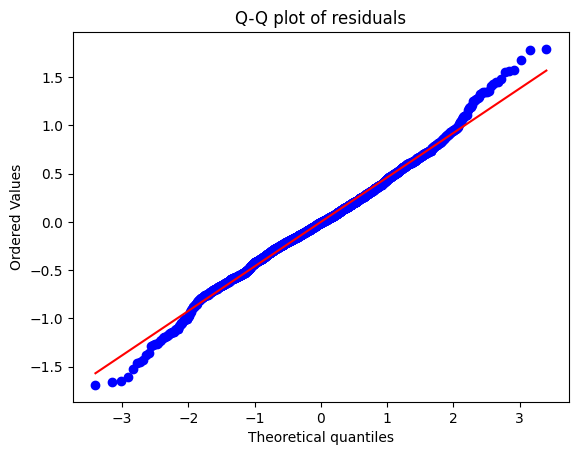

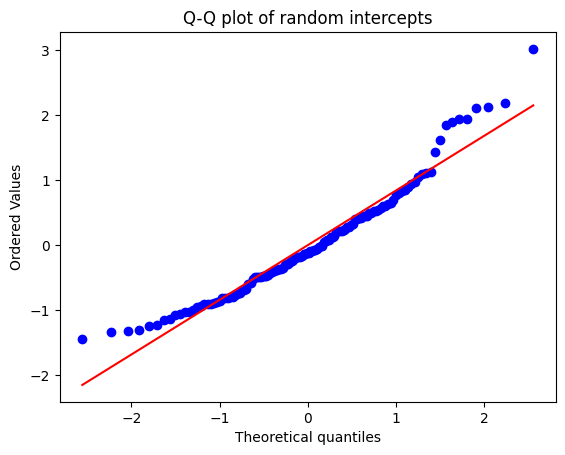

Shapiro-Wilk test for random intercepts: stat=0.950, p=0.000
Random intercepts NOT Gaussian


In [12]:
# Check model assumptions
assumptions(df=df, DVs=['headRel_ed_vel_REC'], formula=f"~ diff * C(conv_type, Treatment(reference='NDirect')) * C(pair, Treatment(reference='pseudo'))")